In [2]:
%run lib/startup.py

10.43.0.66
dict_items([('spark.app.name', 'spark on MLBP'), ('spark.master', 'spark://spark-master:7077'), ('spark.blockmanager.port', '50002'), ('spark.driver.bindAddress', '10.43.0.66'), ('spark.driver.host', '10.43.0.66'), ('spark.driver.port', '50500'), ('spark.cores.max', '2'), ('spark.executor.memory', '512m'), ('spark.authenticate', 'False')])
sparkContext= <SparkContext master=spark://spark-master:7077 appName=spark on MLBP>

    pandas as    pd 	version=1.1.5 	required version>=0.19.2

     numpy as    np 	version=1.19.2 	required version>=1.12.0

   sklearn as    sk 	version=0.24.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.4.4 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.6.3 	required version>=6.0.0

version of ipwidgets= 7.6.3
measurements is a Dataframe with 37608615 records
stations is a Dataframe with 118492 records


In [5]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

from sklearn.datasets import make_blobs

Populating the interactive namespace from numpy and matplotlib


### Kmeans using MLlib
We start with synthetic data

In [7]:
n_samples = 5000
random_state = 170
n_features=2
n_centers=3
X, y, orig_centers= make_blobs(n_samples=n_samples, centers=n_centers, n_features=n_features, \
                  random_state=random_state,return_centers=True)
X.shape, y.shape

((5000, 2), (5000,))

In [8]:
G=[X[i,:] for i in range(X.shape[0])]  # transform 2D numpy array into a list of 1D arrays
parsedData=sc.parallelize(G)           # create an RDD
parsedData.count()

5000

#### Passing additional parameters to a map command
* The interface to the function inside a map allows only a single parameter: an element of the RDD
* Additional parameters, that stay fixed across RDD elements, can be passed through the environment of the function.

In [9]:
# Evaluate clustering by computing Sum of Squared Errors

def mean_error(clusters,points):
    # 'error' is defined within 'mean_error' so that it inherits 'clusters'
    def error(point): 
        center = clusters.centers[clusters.predict(point)]
        return np.sqrt(np.sum((point - center)**2))

    error_av=points.map(lambda point: (error(point),1))\
             .reduce(lambda x, y: (x[0] + y[0],x[1]+y[1]))
    return error_av[0]/error_av[1]
                                                             

In [10]:
%%time
clusters = KMeans.train(parsedData, k=3, maxIterations=10, initializationMode="k-means||",)

CPU times: user 14.9 ms, sys: 6.2 ms, total: 21.1 ms
Wall time: 2.93 s


In [11]:
orig_centers

array([[-8.94709165, -5.46276435],
       [-4.58938989,  0.08876178],
       [ 1.93875432,  0.50513613]])

In [12]:
clusters.centers

[array([-8.94710203, -5.51613184]),
 array([1.89450492, 0.5009336 ]),
 array([-4.55676387,  0.04603707])]

In [13]:
mean_error(clusters,parsedData)

1.2358250460462568

### Relation between mean_error and number of clusters (k)

In [14]:
%%time
E={}
for k in [1,2,3,5,10,50,100]:
    clusters = KMeans.train(parsedData, k=k, maxIterations=10, initializationMode="k-means||")
    E[k]=mean_error(clusters,parsedData)


CPU times: user 220 ms, sys: 58.9 ms, total: 279 ms
Wall time: 13.8 s


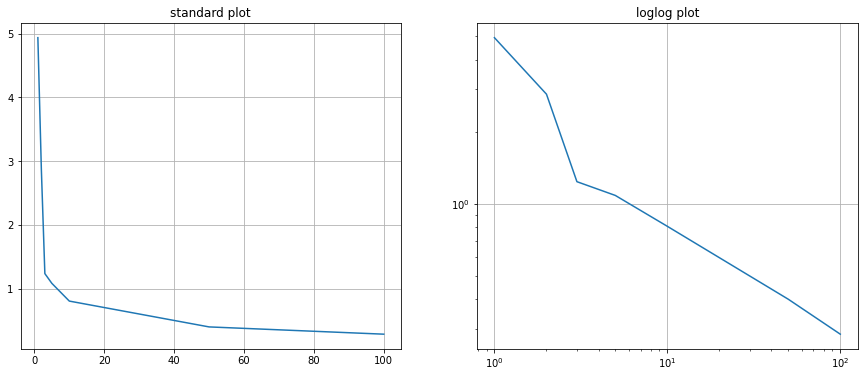

In [15]:
figure(figsize=[15,6])
K=[]
D=[]
for k,d in E.items():
    K.append(k)
    D.append(d)
subplot(1,2,1)
plot(K,D);
grid()
title('standard plot')
subplot(1,2,2)
loglog(K,D);
title('loglog plot')
grid()

#### Can you calculate the intrinsic dimension?

### Doing the analysis on TOBS.
We now do estimate of intrinsic dimension for TOBS_S10 in California

In [16]:
Tobs=measurements.filter(measurements.Measurement=='TOBS_S10')\
     .filter(measurements.state=='CA')\
     .rdd.map(unpackAndScale)\
     .filter(lambda x:np.sum(np.isnan(x))==0).sample(False,0.3)

In [17]:
%%time 
Tobs.count()

CPU times: user 38.3 ms, sys: 27.9 ms, total: 66.1 ms
Wall time: 16.2 s


6642

In [19]:
%%time
sample=Tobs.sample(False,0.01).collect()

CPU times: user 40.9 ms, sys: 15.5 ms, total: 56.4 ms
Wall time: 14 s


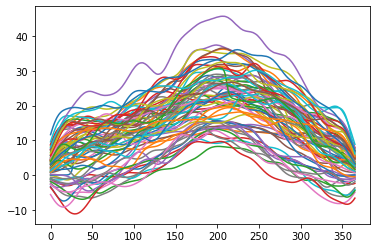

In [20]:
for s in sample:
    plot(s);

In [21]:
%%time
clusters = KMeans.train(Tobs, k=10, maxIterations=30, initializationMode="k-means||")

CPU times: user 438 ms, sys: 338 ms, total: 775 ms
Wall time: 43.5 s


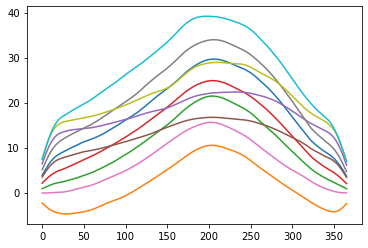

In [22]:
for center in clusters.centers:
    plot(center);

In [23]:
mean_error(clusters,Tobs)

43.92117282680743

### calculating relationship between k and mean error

In [24]:
from time import time
cl={}
err={}
t=time()
for k in [5,10,20,50,100,200,500]:
    cl[k] = KMeans.train(Tobs, k=k, maxIterations=30, initializationMode="k-means||")
    err[k] = mean_error(cl[k],Tobs)
    print('finished %d, time=%5.2f'%(k,time()-t))
    t=time()

finished 5, time=58.19
finished 10, time=57.16
finished 20, time=59.70
finished 50, time=64.21
finished 100, time=70.87
finished 200, time=69.94
finished 500, time=69.86


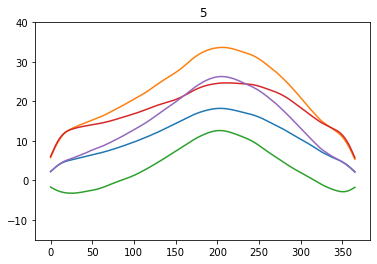

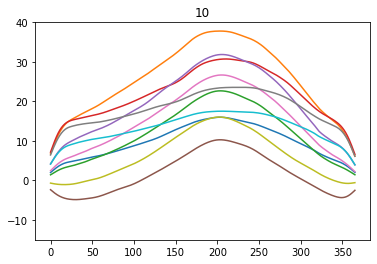

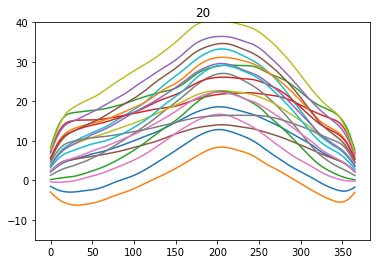

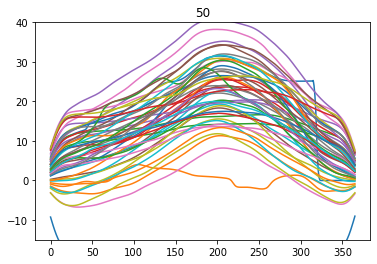

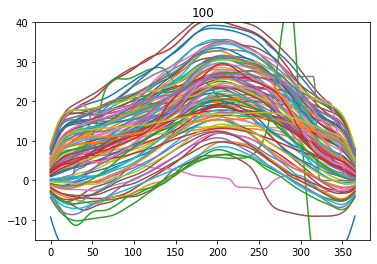

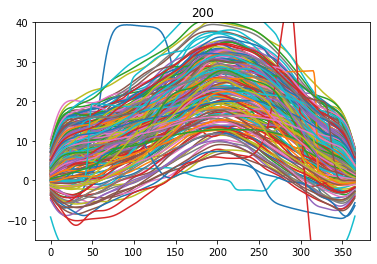

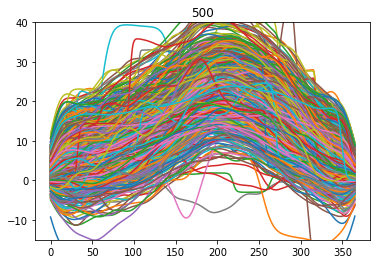

<Figure size 432x288 with 0 Axes>

In [25]:
for k in cl.keys():
    for center in cl[k].centers:
        plot(center);
    ylim([-15,40])
    title(str(k))
    figure()

In [26]:
err

{5: 54.5222718247629,
 10: 44.05210248125214,
 20: 37.77961598007031,
 50: 32.79597653379021,
 100: 30.24564332902596,
 200: 27.818249872294853,
 500: 24.372028497981024}

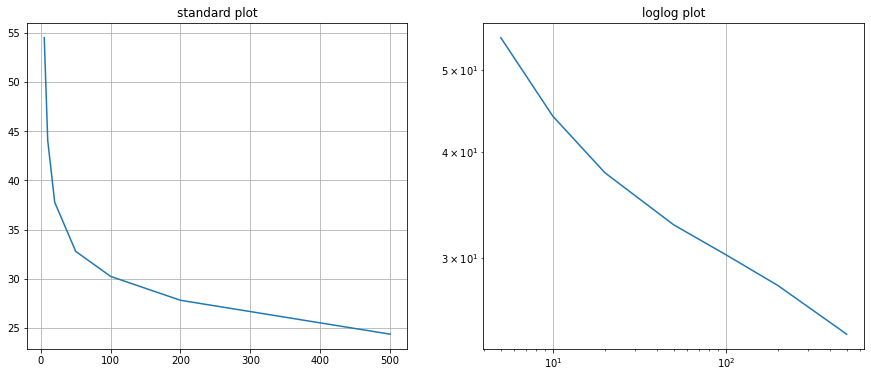

In [27]:
figure(figsize=[15,6])
K=[]
D=[]
for k,d in err.items():
    K.append(k)
    D.append(d)
subplot(1,2,1)
plot(K,D);
grid()
title('standard plot')
subplot(1,2,2)
loglog(K,D);
title('loglog plot')
grid()

### Calculating the dimension

In [29]:
(log(500)-log(5))/(log(err[5])-log(err[500]))

5.71947791550555